In [1]:
import torch
import torch.nn as nn
from einops import rearrange

class PatchEmbed3D(nn.Module):
    def __init__(self, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=1)

    def forward(self, x):
        return self.proj(x)

class SwinBlock3D(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        B, C, T, H, W = x.shape
        x = rearrange(x, 'b c t h w -> b (t h w) c')
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return rearrange(x, 'b (t h w) c -> b c t h w', t=T, h=H, w=W)

class Swin3DNet(nn.Module):
    def __init__(self, in_channels=4, embed_dim=32, num_heads=4, input_shape=(6, 64, 64), pred_steps=3):
        super().__init__()
        T, H, W = input_shape
        self.pred_steps = pred_steps

        self.patch_embed = PatchEmbed3D(in_channels, embed_dim)
        self.encoder = SwinBlock3D(embed_dim, num_heads)

        # Positional encoding [1, C, T, H, W]
        self.pos_embed = nn.Parameter(torch.zeros(1, embed_dim, T, H, W))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # Output temporal steps: T (reconstruction) + k (prediction)
        self.decoder_conv = nn.Sequential(
            nn.Conv3d(embed_dim + in_channels, 32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv3d(32, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv3d(16, T + pred_steps, kernel_size=1)  # output all time steps
        )

    def forward(self, x):  # x: [B, C, T, H, W]
        B, C, T, H, W = x.shape
        x_embed = self.patch_embed(x) + self.pos_embed[:, :, :T, :H, :W]
        encoded = self.encoder(x_embed)

        x_cat = torch.cat([encoded, x], dim=1)
        decoded = self.decoder_conv(x_cat)  # [B, T+k, T, H, W] — but output dim is temporal along channel

        return decoded  # [B, T + k, T, H, W] → e.g., output[:, T:, -1] are k-step predictions


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Swin3DNet(in_channels=4, embed_dim=32, num_heads=4).to(device)
print(model)


Swin3DNet(
  (patch_embed): PatchEmbed3D(
    (proj): Conv3d(4, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (encoder): SwinBlock3D(
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder_conv): Sequential(
    (0): Conv3d(36, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): GELU(approximate='none')
    (2): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): GELU(approximate='none')
    (4): Conv3d(16, 9, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
)


In [125]:
import numpy as np

def fourier_positional_encoding(x, D=32, lambda_min=0.01, lambda_max=720.0):
    """
    Encode scalar grid x using sinusoidal Fourier encoding.
    x: [B, H, W]
    Returns: [B, H, W, D]
    """
    x = x.unsqueeze(-1)
    i = torch.arange(0, D // 2, dtype=torch.float32, device=x.device)
    lambdas = torch.exp(torch.log(torch.tensor(lambda_min)) + i * (np.log(lambda_max / lambda_min) / (D // 2 - 1)))
    enc = 2 * np.pi * x / lambdas
    return torch.cat([torch.cos(enc), torch.sin(enc)], dim=-1)  # [B, H, W, D]


In [126]:

import torch

# Simulated parameters
B = 4       # batch size
C = 4       # number of input channels (InSAR, Sd, Sg, S0)
T = 6       # number of past time steps
H = 64      # spatial height
W = 64      # spatial width

# Dummy input: 4 features over 6 time steps
x_input = torch.randn(B, C, T, H, W)

# Dummy target: predict Sg or EWH at time T+1
# y_target = torch.randn(B, 1, H, W)
# Learnable target
y_target = (x_input[:, 0, -1] * 0.3 + x_input[:, 1, -1] * 0.5 + x_input[:, 2, -1] * 0.2).unsqueeze(1)

print("Input shape:", x_input.shape)     # [4, 4, 6, 64, 64]
print("Target shape:", y_target.shape)   # [4, 1, 64, 64]


Input shape: torch.Size([4, 4, 6, 64, 64])
Target shape: torch.Size([4, 1, 64, 64])


In [127]:
# Build dummy lat/lon grid (simulate geographic coverage)
B, _, T, H, W = x_input.shape
lat = torch.linspace(45, 46, H).view(1, H, 1).expand(B, H, W).to(x_input.device)
lon = torch.linspace(9, 10, W).view(1, 1, W).expand(B, H, W).to(x_input.device)

# Encode lat/lon using Fourier features
lat_enc = fourier_positional_encoding(lat, D=32)  # [B, H, W, 32]
lon_enc = fourier_positional_encoding(lon, D=32)  # [B, H, W, 32]
pos_enc = torch.cat([lat_enc, lon_enc], dim=-1)   # [B, H, W, 64]
pos_enc = pos_enc.permute(0, 3, 1, 2)              # [B, 64, H, W]
pos_enc = pos_enc.unsqueeze(2).repeat(1, 1, T, 1, 1)  # [B, 64, T, H, W]

# Concatenate to input
x_input = torch.cat([x_input, pos_enc], dim=1)  # new input: [B, 4+64, T, H, W]


In [128]:
class PatchEmbed3D(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size=(2, 2, 2)):
        super().__init__()
        self.patch_size = patch_size
        #self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=(2, 2, 2), stride=(2, 2, 2))

    def forward(self, x):  # x: [B, C, T, H, W]
        x = self.proj(x)   # → [B, embed_dim, T', H', W']
        return x


class SwinBlock3D(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):  # x: [B, C, T, H, W]
        B, C, T, H, W = x.shape
        x = x.permute(0, 2, 3, 4, 1).reshape(B * T * H * W, C)
        x = self.norm1(x)
        x, _ = self.attn(x.unsqueeze(0), x.unsqueeze(0), x.unsqueeze(0))
        x = self.norm2(x.squeeze(0))
        x = self.mlp(x)
        x = x.view(B, T, H, W, C).permute(0, 4, 1, 2, 3)  # [B, C, T, H, W]
        return x


class Swin3DNet(nn.Module):
    def __init__(self, in_channels=64, embed_dim=32, num_heads=4):
        super().__init__()
        self.patch_embed = PatchEmbed3D(in_channels, embed_dim)
        self.encoder = SwinBlock3D(embed_dim, num_heads)
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(embed_dim, 16, kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.GELU(),
            nn.Conv3d(16, 1, kernel_size=1)  # predict 1 output channel (e.g., Sg at t+1)
        )

    def forward(self, x):  # x: [B, C, T, H, W]
        x = self.patch_embed(x)     # [B, embed_dim, T', H', W']
        x = self.encoder(x)         # same shape
        x = self.decoder(x)         # [B, 1, T, H, W]
        return x[:, :, -1]          # return last time slice only → [B, 1, H, W]


In [129]:
model = Swin3DNet(in_channels=68)  # ← 4 original + 64 position
output = model(x_input)

print("Predicted shape:", output.shape)
assert output.shape == y_target.shape



Predicted shape: torch.Size([4, 1, 64, 64])


In [130]:
import torch.nn as nn
import torch.optim as optim

# Define model (from previous step)
model = Swin3DNet(in_channels=68)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Send data to device
x_input = x_input.to(device)
y_target = y_target.to(device)

# Loss: MSE
criterion = nn.MSELoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [131]:
# Initialize empty list before training loop
loss_history = []

# Training loop
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(x_input)              # Forward pass
    loss = criterion(output, y_target)  # Loss
    loss.backward()                     # Backpropagation
    optimizer.step()                    # Update weights

    # Store loss as float
    loss_history.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")


Epoch [1/20] - Loss: 0.4166
Epoch [2/20] - Loss: 0.4154
Epoch [3/20] - Loss: 0.4141
Epoch [4/20] - Loss: 0.4129
Epoch [5/20] - Loss: 0.4118
Epoch [6/20] - Loss: 0.4108
Epoch [7/20] - Loss: 0.4098
Epoch [8/20] - Loss: 0.4090
Epoch [9/20] - Loss: 0.4082
Epoch [10/20] - Loss: 0.4074
Epoch [11/20] - Loss: 0.4067
Epoch [12/20] - Loss: 0.4060
Epoch [13/20] - Loss: 0.4053
Epoch [14/20] - Loss: 0.4046
Epoch [15/20] - Loss: 0.4039
Epoch [16/20] - Loss: 0.4032
Epoch [17/20] - Loss: 0.4025
Epoch [18/20] - Loss: 0.4019
Epoch [19/20] - Loss: 0.4012
Epoch [20/20] - Loss: 0.4006


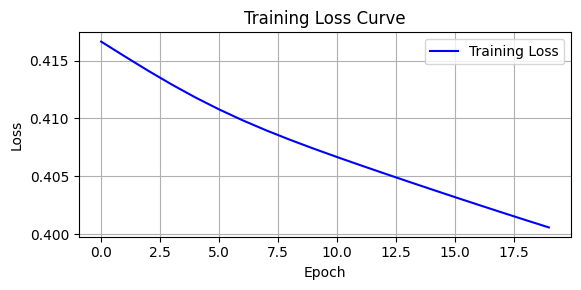

In [132]:
# After training loop
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [133]:
import matplotlib.pyplot as plt

# 1️⃣ Plot InSAR time series at one pixel
def plot_timeseries_at_pixel(data, pixel_coords=(32, 32), channel_index=0, label='Variable'):
    """
    Plot the time series at a specific pixel for a given input channel (e.g., InSAR).
    data: Tensor of shape [B, C, T, H, W]
    """
    B, C, T, H, W = data.shape
    plt.figure(figsize=(8, 4))
    for b in range(B):
        ts = data[b, channel_index, :, pixel_coords[0], pixel_coords[1]].cpu().numpy()
        plt.plot(range(T), ts, label=f'Batch {b+1}')
    plt.title(f'Time Series of {label} at Pixel {pixel_coords}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 2️⃣ Plot predicted Sg(t+1) vs true Sg(t+1) at one pixel
def plot_prediction_at_pixel(x_input, y_target, output, pixel=(32, 32), batch_idx=0):
    """
    Plot InSAR input + true Sg(t+1) and predicted Sg(t+1) at a pixel.
    x_input: [B, C, T, H, W] (channel 0 = InSAR)
    y_target: [B, 1, H, W]
    output: [B, 1, H, W]
    """
    insar_ts = x_input[batch_idx, 0, :, pixel[0], pixel[1]].cpu().numpy()
    sg_true = y_target[batch_idx, 0, pixel[0], pixel[1]].cpu().numpy()
    sg_pred = output[batch_idx, 0, pixel[0], pixel[1]].detach().cpu().numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(insar_ts)), insar_ts, label='InSAR Deformation (Input)', marker='o')
    plt.axvline(x=len(insar_ts), linestyle='--', color='gray')
    plt.plot([len(insar_ts)], [sg_true], 'go', label='True Sg t+1')
    plt.plot([len(insar_ts)], [sg_pred], 'ro', label='Predicted Sg t+1')
    plt.title(f'InSAR to Sg(t+1) Prediction at Pixel {pixel}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 3️⃣ Plot side-by-side spatial map of true vs predicted Sg
def plot_sg_comparison(sg_true, sg_pred, batch_index=0):
    """
    Compare predicted and true Sg(t+1) spatially.
    sg_true, sg_pred: tensors [B, 1, H, W]
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(sg_true[batch_index, 0].cpu().numpy(), cmap='viridis')
    axs[0].set_title('Sg Ground Truth (t+1)')
    axs[0].axis('off')

    axs[1].imshow(sg_pred[batch_index, 0].detach().cpu().numpy(), cmap='magma')
    axs[1].set_title('Sg Prediction (t+1)')
    axs[1].axis('off')

    plt.suptitle(f'Sg Map Comparison - Batch {batch_index}')
    plt.tight_layout()
    plt.show()


# 4️⃣ Plot all time-step maps for a single variable
def plot_spatiotemporal_maps(data, channel_index=0, batch_index=0, title='Channel'):
    """
    Plot maps across time for a single variable (e.g., InSAR or W3RA).
    data: [B, C, T, H, W]
    """
    B, C, T, H, W = data.shape
    fig, axs = plt.subplots(1, T, figsize=(3*T, 3))
    for t in range(T):
        axs[t].imshow(data[batch_index, channel_index, t].cpu().numpy(), cmap='gray')
        axs[t].set_title(f'Time {t}')
        axs[t].axis('off')
    plt.suptitle(f'{title} Over Time (Batch {batch_index})')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def show_map_with_values(tensor_2d, title='Map with Values'):
    """
    Visualize a 2D tensor as an image with pixel values.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(tensor_2d.cpu().numpy(), cmap='viridis')
    for i in range(tensor_2d.shape[0]):
        for j in range(tensor_2d.shape[1]):
            ax.text(j, i, f"{tensor_2d[i, j]:.1f}", ha='center', va='center', fontsize=6, color='white')
    ax.set_title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()



🔹 Plotting InSAR time series at pixel (32, 32)


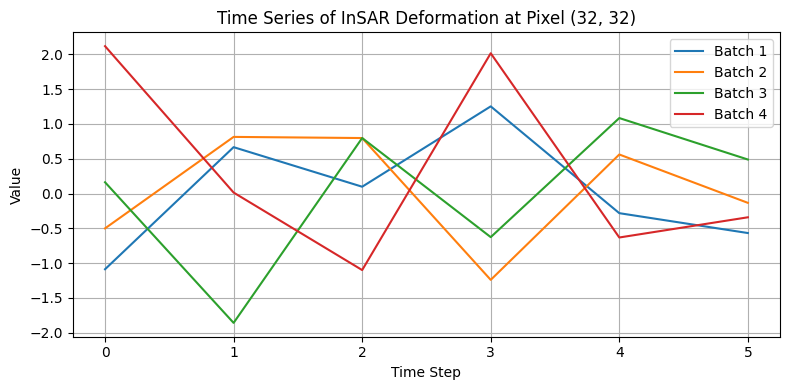

In [134]:
pixel = (32, 32)
print(f"🔹 Plotting InSAR time series at pixel {pixel}")
plot_timeseries_at_pixel(
    data=x_input, 
    pixel_coords=pixel, 
    channel_index=0,  # InSAR is channel 0
    label='InSAR Deformation'
)


🔹 Plotting spatial maps of InSAR deformation over all time steps


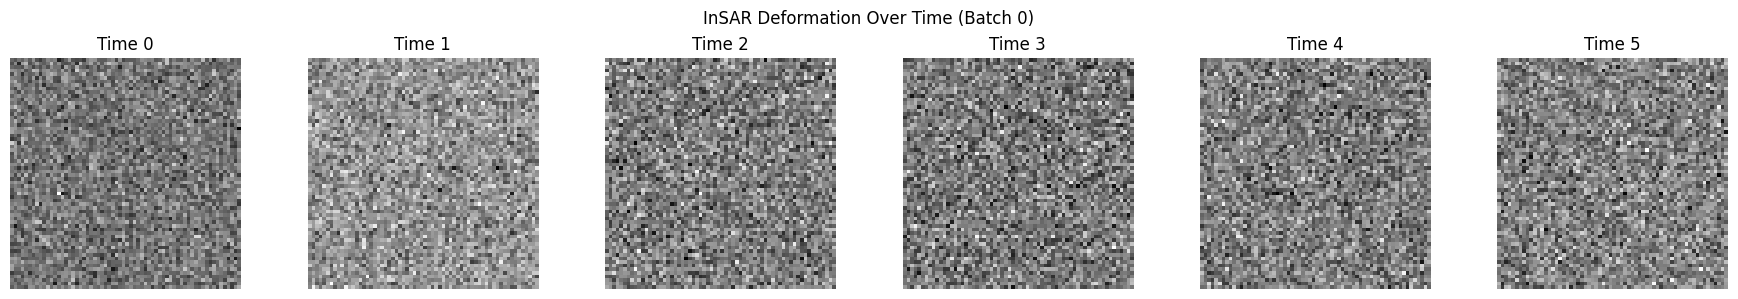

In [135]:
print("🔹 Plotting spatial maps of InSAR deformation over all time steps")
plot_spatiotemporal_maps(
    data=x_input,
    channel_index=0,  # InSAR
    batch_index=0,
    title='InSAR Deformation'
)


🔹 Plotting prediction vs true Sg at pixel (32, 32)


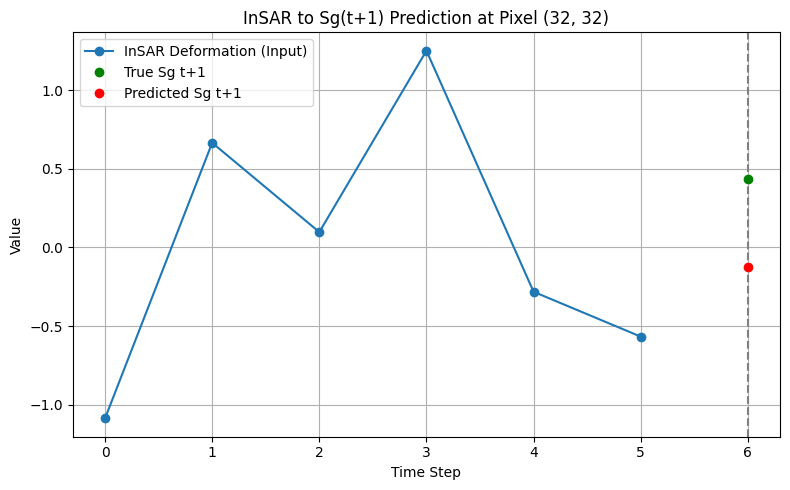

In [136]:
print(f"🔹 Plotting prediction vs true Sg at pixel {pixel}")
plot_prediction_at_pixel(
    x_input=x_input, 
    y_target=y_target, 
    output=output, 
    pixel=pixel, 
    batch_idx=0
)


🔹 Plotting Sg spatial map comparison (true vs predicted)


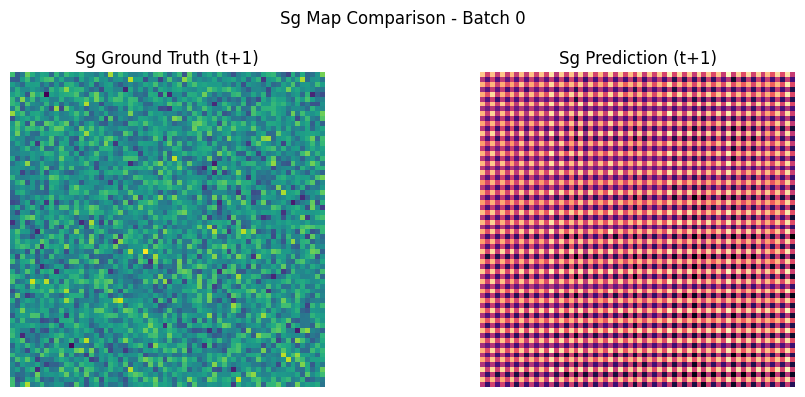

In [137]:
print("🔹 Plotting Sg spatial map comparison (true vs predicted)")
plot_sg_comparison(
    sg_true=y_target, 
    sg_pred=output, 
    batch_index=0
)


In [138]:
def show_map_with_values(data_2d, title="Map with Values", cmap='viridis'):
    """
    Show a 2D map with color values and overlaid text labels.
    """
    plt.figure(figsize=(6, 5))
    im = plt.imshow(data_2d.cpu().detach().numpy(), cmap=cmap)
    plt.title(title)
    plt.colorbar(im, shrink=0.75)
    
    H, W = data_2d.shape
    for i in range(H):
        for j in range(W):
            val = data_2d[i, j].item()
            plt.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=7, color='white')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()


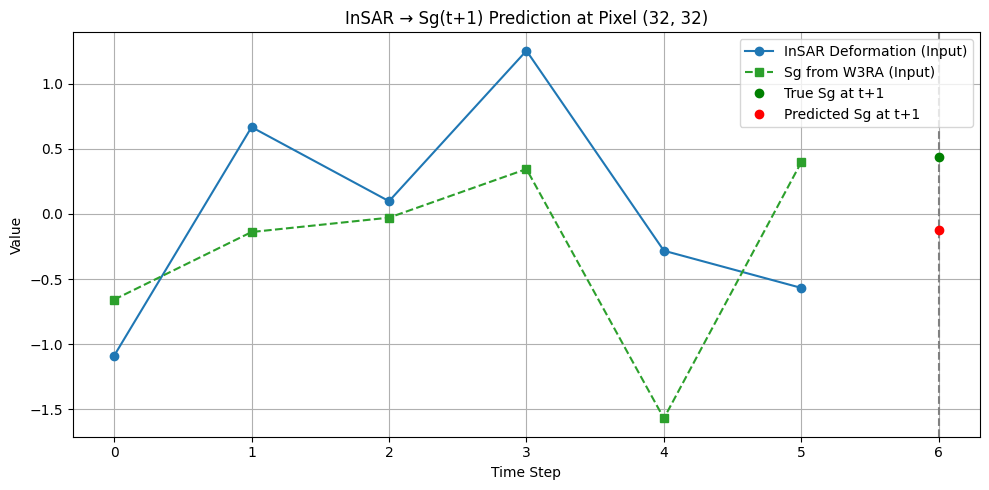

In [139]:
import matplotlib.pyplot as plt

# Choose pixel and batch
pixel = (32, 32)
batch_idx = 0

# Extract values
insar_ts = x_input[batch_idx, 0, :, pixel[0], pixel[1]].cpu().numpy()       # InSAR deformation (input)
sg_ts    = x_input[batch_idx, 2, :, pixel[0], pixel[1]].cpu().numpy()       # Sg history from W3RA
sg_true  = y_target[batch_idx, 0, pixel[0], pixel[1]].cpu().numpy()         # True Sg(t+1)
sg_pred  = output[batch_idx, 0, pixel[0], pixel[1]].detach().cpu().numpy()  # Predicted Sg(t+1)

# Plotting
T = insar_ts.shape[0]
plt.figure(figsize=(10, 5))
plt.plot(range(T), insar_ts, 'o-', label='InSAR Deformation (Input)', color='tab:blue')
plt.plot(range(T), sg_ts, 's--', label='Sg from W3RA (Input)', color='tab:green')

plt.axvline(x=T, color='gray', linestyle='--')
plt.plot(T, sg_true, 'o', label='True Sg at t+1', color='green')
plt.plot(T, sg_pred, 'o', label='Predicted Sg at t+1', color='red')

plt.title(f"InSAR → Sg(t+1) Prediction at Pixel {pixel}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

